In [1]:
import h5py
import numpy as np
import scipy
import itertools
from scipy.io import loadmat
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix

import pandas as pd
import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential
from tensorflow.keras.layers import Reshape, Flatten, Dense, Conv1D ,Conv2D, MaxPooling2D, MaxPooling1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-11-01 18:14:56.121728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user12/Radio/lib/:
2022-11-01 18:14:56.121759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.7.0


In [2]:
def evaluation_tf(report, y_test, y_pred, classes):
    plt.plot(report.history['loss'], label = 'training_loss')
    plt.plot(report.history['val_loss'], label = 'validation_loss')
    plt.legend()
    plt.show()
    plt.plot(report.history['accuracy'], label = 'training_accuracy')
    plt.plot(report.history['val_accuracy'], label = 'validation_accuracy')
    plt.legend()
    plt.show()
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, cmap=plt.cm.Blues)
    print(cm.shape[0],cm.shape[1])
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], 'd'),
                 horizontalalignment = 'center',
                 color='black')

    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

In [3]:
#Now we can go ahead and create our Convolution model
model = Sequential()

#We want to output 32 features maps. The kernel size is going to be
#2x4 and we specify our input shape to be 256,4 
#Padding=same means we want the same dimensional output as input
#activation specifies the activation function
model.add(Conv1D(32, 2, input_shape=(512, 4), padding='same',
                       activation='tanh', name="conv1"))

# Size --> (256,32)
#now we add another convolution layer, again with a 4x4 kernel
#This time our padding=valid this means that the output dimension can
#take any form
model.add(Conv1D(64, 4, activation='relu', padding='same', name="conv2"))

# Size --> (256,64)
#maxpool with a kernet of 2x2
model.add(MaxPooling1D(pool_size=2, name="maxpool1"))

# Size --> (128,64)
#now we add another convolution layer, again with a 8 kernel
#This time our padding=valid this means that the output dimension can
#take any form
model.add(Conv1D(96, 8, activation='relu', padding='same', name="conv3"))

# Size --> (128,128,1)
#maxpool with a kernet of 2x2
model.add(MaxPooling1D(pool_size=2, name="maxpool2"))

# Size --> (32,8,64)
model.add(Conv1D(128, 12, activation='relu', padding='same', name="conv4"))



#In a convolution NN, we neet to flatten our data before we can
#input it into the ouput/dense layer
model.add(Flatten())

#Dense layer with 1024 hidden units
model.add(Dense(128, activation='relu'))

#this time we set 25% of the nodes to 0 to minimize overfitting
model.add(Dropout(0.1))

#Dense layer with 1024 hidden units
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.1))
#Finally the output dense layer with 10 hidden units corresponding to
#our 7 classes
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, 512, 32)           288       
                                                                 
 conv2 (Conv1D)              (None, 512, 64)           8256      
                                                                 
 maxpool1 (MaxPooling1D)     (None, 256, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 256, 96)           49248     
                                                                 
 maxpool2 (MaxPooling1D)     (None, 128, 96)           0         
                                                                 
 conv4 (Conv1D)              (None, 128, 128)          147584    
                                                                 
 flatten (Flatten)           (None, 16384)             0

2022-11-01 18:14:57.316054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user12/Radio/lib/:
2022-11-01 18:14:57.316092: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 18:14:57.316118: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ipt-Precision-7920-Tower): /proc/driver/nvidia/version does not exist
2022-11-01 18:14:57.316380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [5]:
filename = "./processed1.h5"
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())
print (a_group_key)


['Data', 'Label']


In [6]:
data = np.array(f[a_group_key[0]])            #(600000, 256, 4)
datatype = np.array(f[a_group_key[1]])         #(600000, 1)
#SNR = np.array(f[a_group_key[2]])               #(600000, 1)

print(data.shape)
print(datatype.shape)
#print(SNR.shape)

(318001, 512, 4)
(318001, 1)


In [7]:
print(type(data)) 
print(type(datatype))
#print(type(SNR))

print(data.shape)
print(datatype.shape)
#print(SNR.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(318001, 512, 4)
(318001, 1)


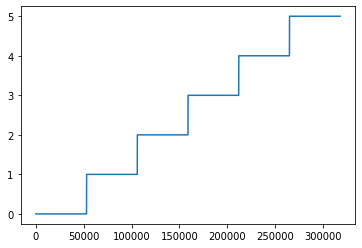

In [8]:
#point = 800
#plt.plot(data[point,:,0])
#plt.plot(data[point,:,1])
#plt.plot(data[point,:,2])
#plt.plot(data[point,:,3])

plt.plot(datatype)

plt.show()

#print(data[point,:,0])
#print(datatype[point])
#print(SNR[point])

# 0--BPSK , 2--PSK16, 3--PSK8 ,4--QAM16 , 5--QAM32 , 6--QPSK , 
# [-4:2:14]

In [9]:
#data = f[a_group_key[0]]              #(600000, 256, 4)
#datatype = f[a_group_key[1]]          #(600000, 1)
#SNR = f[a_group_key[2]]               #(600000, 1)


#print(data.shape)
#print(datatype.shape)
#print(SNR.shape)

# Six different Modulation each with 100000 in length
# SNR... 10 bins for each modulation

# Result should be list of pair--- (16 symbols packet--- 256, Modulation Scheme (0...5))

# Write into pre-processed training data!

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, datatype, test_size = 0.2)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
                
                

(254400, 512, 4)
(63601, 512, 4)
(254400, 1)
(63601, 1)


In [12]:
report = model.fit(X_train, y_train, epochs = 10, validation_data=(X_test, y_test))

Epoch 1/10
7950/7950 [==============================] - 283s 36ms/step - loss: 0.3890 - accuracy: 0.8238 - val_loss: 0.1973 - val_accuracy: 0.9272
Epoch 2/10
7950/7950 [==============================] - 275s 35ms/step - loss: 0.1803 - accuracy: 0.9355 - val_loss: 0.1522 - val_accuracy: 0.9456
Epoch 3/10
7950/7950 [==============================] - 286s 36ms/step - loss: 0.1375 - accuracy: 0.9534 - val_loss: 0.1342 - val_accuracy: 0.9535
Epoch 4/10
7950/7950 [==============================] - 301s 38ms/step - loss: 0.1207 - accuracy: 0.9594 - val_loss: 0.1492 - val_accuracy: 0.9495
Epoch 5/10
7950/7950 [==============================] - 323s 41ms/step - loss: 0.1109 - accuracy: 0.9634 - val_loss: 0.1536 - val_accuracy: 0.9559
Epoch 6/10
7950/7950 [==============================] - 334s 42ms/step - loss: 0.0996 - accuracy: 0.9673 - val_loss: 0.1041 - val_accuracy: 0.9680
Epoch 7/10
7950/7950 [==============================] - 348s 44ms/step - loss: 0.0970 - accuracy: 0.9688 - val_loss: 0

In [13]:
model.save('Mod_3L_4D_NL_tan_16S16_1024_1.h5')

In [14]:
y_pred = model.predict(X_test).argmax(axis = 1)

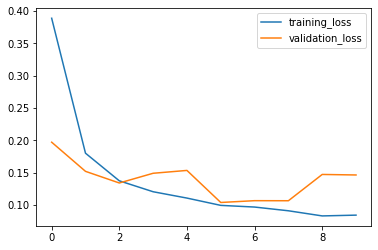

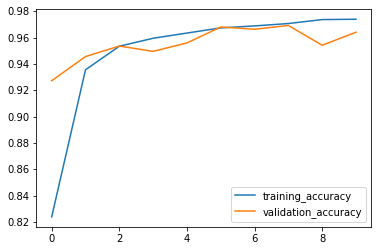

6 6


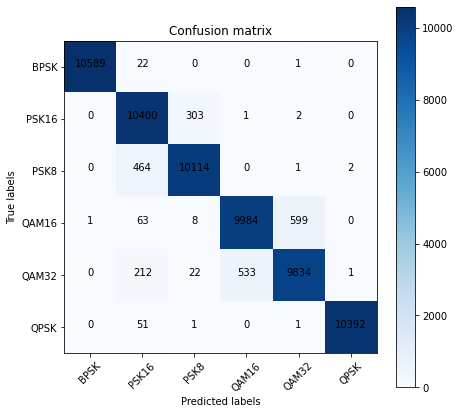

In [15]:
# 0--BPSK , 2--PSK16, 3--PSK8 ,4--QAM16 , 5--QAM32 , 6--QPSK ,
Y = ['BPSK','PSK16','PSK8','QAM16','QAM32', 'QPSK']
evaluation_tf(report, y_test, y_pred, Y)